In [17]:
# https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
'''i think convolve and convolve2d are the same'''
''' scipy.ndimage.filters.convolve is about twice as fast as scipy.signal.convolve2d.'''

from scipy import signal
from scipy import ndimage
from PIL import Image,ImageOps
import numpy as np
import matplotlib.pyplot as plt


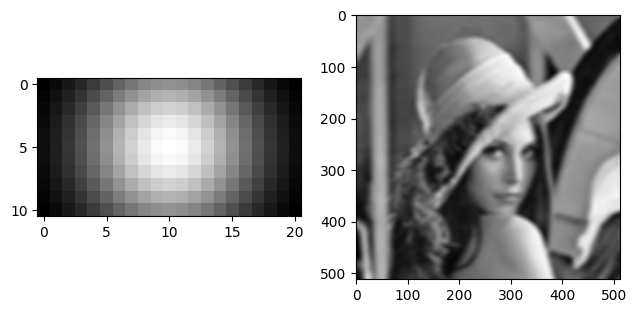

In [32]:
image = Image.open('../../assets/lenna.png')
image = np.asarray(image)

# bgr to gray

r, g, b = image[..., 2], image[..., 1], image[..., 0]
image =  0.2989 * r + 0.5870 * g + 0.1140 * b


# creating the kernel / filter

sigma = 5
# filter_size = 2 * int(4 * sigma + 0.5) + 1
filter_size = (10,20)
size_y = filter_size[0] // 2
size_x = filter_size[1] // 2

x, y = np.mgrid[-size_y:size_y+1, -size_x:size_x+1]
normal = 1 / (2.0 * np.pi * sigma**2)
gaussian_filter = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal

# convoluiton

filtered = ndimage.convolve(image,gaussian_filter)
filtered = filtered.astype('uint8')

# plotting

plt.gray()

plt.subplot(121)
plt.imshow(gaussian_filter)
plt.subplot(122)
plt.imshow(filtered)
plt.tight_layout()
plt.show()


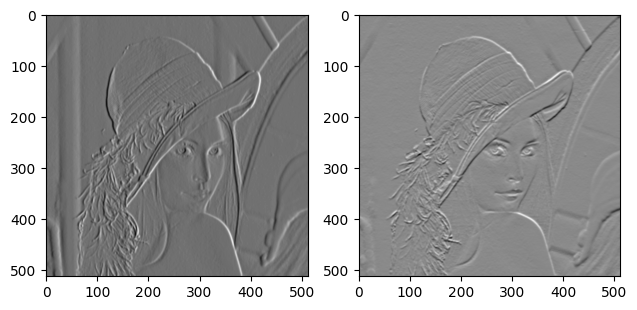

In [19]:
'''Gradient calculation / Sobel Filters'''
Kx = np.array(
    [[-1, 0, 1],
     [-2, 0, 2],
     [-1, 0, 1]], np.float32
)

Ky = np.array(
    [[1, 2, 1],
     [0, 0, 0],
     [-1, -2, -1]], np.float32
)
filtered = filtered / 255
Ix = ndimage.convolve(filtered, Kx)
Iy = ndimage.convolve(filtered, Ky)

plt.subplot(121)
plt.imshow(Ix)
plt.subplot(122)
plt.imshow(Iy)
plt.tight_layout()
plt.show()


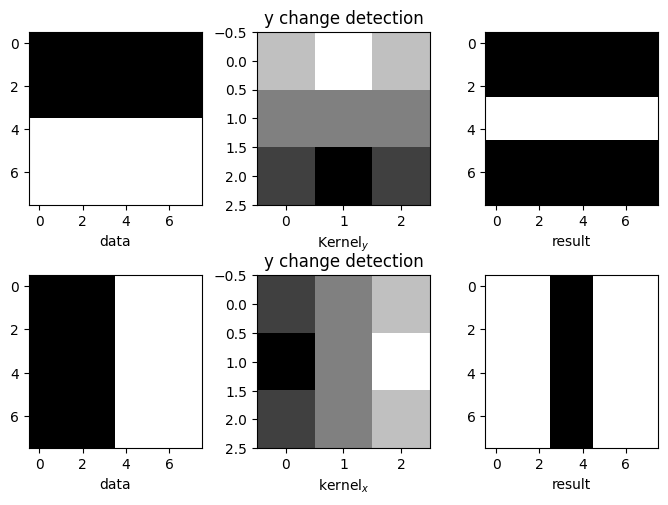

In [20]:
'''paying around with the sobel operator'''
fig,ax = plt.subplots(2,3,figsize=(7,5))
ax = ax.flatten()

row1 = np.tile([1],32).reshape(4,8)
row2 = np.tile([2],32).reshape(4,8)

arr_for_y_change = np.vstack([row1,row2])
arr_for_x_change = np.vstack([row1,row2]).T

res_y_change = ndimage.convolve(arr_for_y_change,Ky)
res_x_change = ndimage.convolve(arr_for_x_change,Kx)


ax[0].set_xlabel('data')
ax[0].imshow(arr_for_y_change)

ax[1].set_title('y change detection')
ax[1].set_xlabel('Kernel$_y$')
ax[1].imshow(Ky)

ax[2].imshow(res_y_change)
ax[2].set_xlabel('result')

ax[3].imshow(arr_for_x_change)
ax[3].set_xlabel('data')

ax[4].set_title('y change detection')
ax[4].imshow(Kx)
ax[4].set_xlabel('kernel$_x$')

ax[5].imshow(res_x_change)
ax[5].set_xlabel('result')

plt.tight_layout()
plt.show()

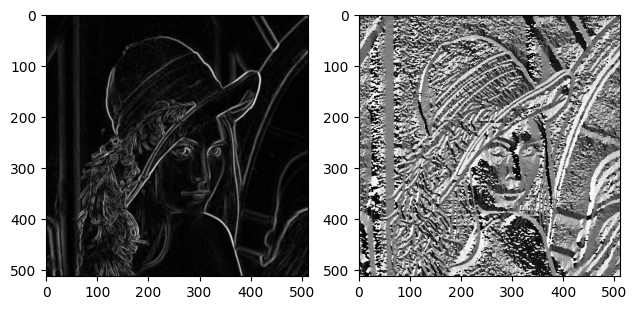

In [21]:
import seaborn as sb
# G = np.sqrt((Ix**2)+(Iy**2))
'''or'''
G = np.hypot(Ix, Iy)

G = G / G.max() * 255

theta = np.arctan2(Iy, Ix)


plt.subplot(121)
plt.imshow(G)
plt.subplot(122)
plt.imshow(theta)
plt.tight_layout()
plt.show()


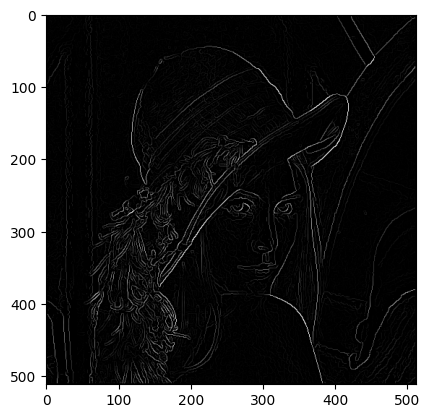

In [22]:
'''Non Max Suppression'''

M, N = G.shape
Z = np.zeros((M,N), dtype=np.int32)
angle = theta * 180. / np.pi    # max -> 180, min -> -180
angle[angle < 0] += 180         # max -> 180, min -> 0

for i in range(1,M-1):
    for j in range(1,N-1):
        q = 255
        r = 255
        
        #angle 0
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
            r = G[i, j-1]
            q = G[i, j+1]
        #angle 45
        elif (22.5 <= angle[i,j] < 67.5):
            r = G[i-1, j+1]
            q = G[i+1, j-1]
        #angle 90
        elif (67.5 <= angle[i,j] < 112.5):
            r = G[i-1, j]
            q = G[i+1, j]
        #angle 135
        elif (112.5 <= angle[i,j] < 157.5):
            r = G[i+1, j+1]
            q = G[i-1, j-1]

        if (G[i,j] >= q) and (G[i,j] >= r):
            Z[i,j] = G[i,j]
        else:
            Z[i,j] = 0


plt.imshow(Z)

In [23]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    '''
    Double threshold
    '''
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)


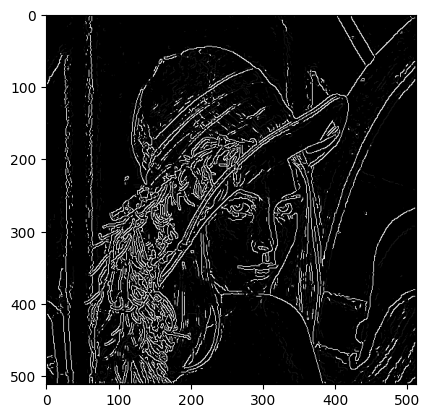

In [24]:
thresholded = threshold(Z,0.5)[0]
plt.imshow(thresholded)


In [25]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i, j] == weak):
                if (
                    (img[i+1, j-1] == strong) or (img[i+1, j] == strong) or
                    (img[i+1, j+1] == strong) or (img[i, j-1] == strong) or
                    (img[i, j+1] == strong) or (img[i-1, j-1] == strong) or
                    (img[i-1, j] == strong) or (img[i-1, j+1] == strong)
                ):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img


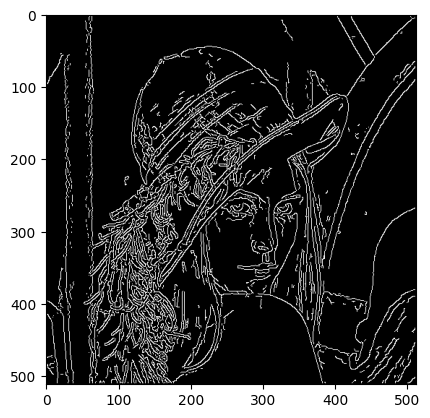

In [26]:
plt.imshow(hysteresis(thresholded,25))